In [29]:
from sympy import MatrixSymbol, Matrix, Identity
import scipy as sci
import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida (archivo class_09.csv), obtenga el modelo estimado usando el modelo ARMAX.

**Paso 1: Lectura de los datos**

C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


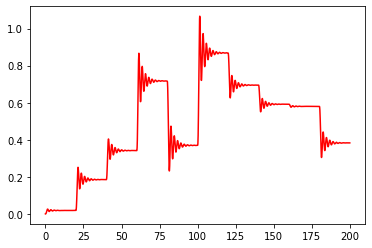

In [30]:
#datos = pd.read_csv ('data\clase_09.csv')
#t = datos.t
#yn = datos.yn
#yn = sci.signal.medfilt(yn,3)
#u = datos.un
datos = pd.read_csv ('data\exportedVariables.csv')
t = datos['time']
yn = datos['G.y']
yn = sci.signal.medfilt(yn,3)
u  = datos['G.u']

N = len(t)

plt.plot(t,yn,color = 'red')
dt = (t[1] - t[0])
dt

## Definiendo la matriz de regresión

**Paso 2:** Proponer el regresor de la estimación ARX y calcular los parámetros $\theta$ de la estimación ARX, para este ejemplo se propone:

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1]]$$

In [31]:
## Definir y_1, y_2, dependiendo el sistema que se quiera modelar, 
## así como u_1, u_2 y las que se requieran

y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=yn[k-3]
    u_3[k]=u[k-3]

## Creación del vector phi
phi = np.array([-y_1,-y_2,-y_3,u_1,u_2,u_3]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 1e-2
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-1.22873576e+00, -3.19083546e-01,  5.73721626e-01,  3.59576933e-04,
        2.52145728e-03,  2.30035122e-02])

In [26]:
t_est = 199
r = 0.005
dfReg = pd.DataFrame(data={'t':t,'y':yn,'y_1':y_1,'y_2':y_2,'y_3':y_3,'u_1':u_1,'u_2':u_2,'u_3':u_3})
dfReg['dy_y1'] = np.abs((dfReg['y'] - dfReg['y_1'])/dfReg['y']) 
dfReg['Estable'] = np.where(dfReg['dy_y1'] <= r,'Estable','Transitorio')
# dfReg['Estable'] = np.where(dfReg['t'] >= t_est,'Estable','Transitorio')
#sns.pairplot(dfReg,hue='Estable')

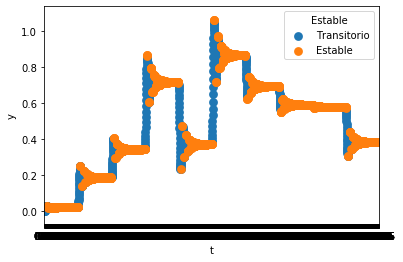

In [28]:
dfRegSample = (dfReg[dfReg['Estable'] == 'Estable'].sample(n=50).
               append(dfReg[dfReg['Estable'] == 'Transitorio'].sample(n=500))).reset_index(drop=True)
sns.pointplot(data = dfReg,x='t',y = 'y',hue='Estable')

In [13]:

## Creación del vector phi
phi3 = np.array([-dfRegSample.y_1,
                -dfRegSample.y_2,
                -dfRegSample.y_3,
                dfRegSample.u_1,
                dfRegSample.u_2,
                dfRegSample.u_3]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0
A3 = np.dot(phi3.T,phi3) + alpha*np.eye(len(np.dot(phi3.T,phi3)))
theta3 = np.dot(np.linalg.inv(A3),np.dot(phi3.T,dfRegSample.y))
theta3

array([-2.65388324e+00,  2.34433677e+00, -6.85878107e-01,  3.11592574e-04,
        1.71673053e-03,  2.54235746e-03])

TransferFunction(array([0.00031159, 0.00171673, 0.00254236]), array([ 1.        , -2.65388324,  2.34433677, -0.68587811]), 0.05)

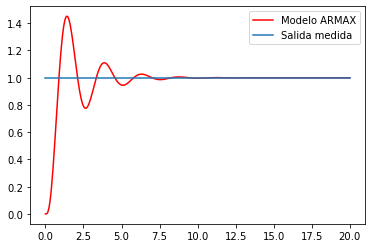

In [17]:
## Armando la función de transferencia estimada con los parámetros hallados
G3 = control.tf([theta3[3],theta3[4],theta3[5]],[1,theta3[0],theta3[1],theta3[2]],dt)

## Se determina la respuesta estimada al escalón
t,y3 = control.step_response(G3,np.linspace(0,20,1+int(20/dt)))

#e3 = yn-y3

plt.plot(t,y3,color = 'red')
plt.plot(t,np.ones(len(t)))
#plt.plot(t,yn,color = 'black')
#plt.plot(t,e2,color = 'green')

plt.legend(['Modelo ARMAX','Salida medida','Error estimacion']);
G3

In [19]:
(theta3[3]+theta3[4]+theta3[5])/(1+theta3[0]+theta3[1]+theta3[2])

## Armando la función estimada ARX

**Paso 3:** Definir la función de transferencia estimada $G_e$

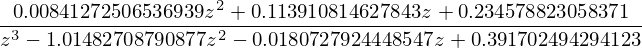

In [61]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2 + theta[2]*z**-3 
B =  theta[3]*z**-1 +theta[4]*z**-2+theta[5]*z**-3  

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()

G

## Calculando la respuesta al step de la estimación

**Paso 4:** Calculamos la respuesta de la función $G_e$ y con esos datos determinamos el error de la estimación inicial.

In [62]:
G_e = control.tf([theta[3],theta[4],theta[5]],[1,theta[0],theta[1],theta[2]],dt)
G_e

TransferFunction(array([0.00841273, 0.11391081, 0.23457882]), array([ 1.        , -1.01482709, -0.01807279,  0.39170249]), 0.2)


  0.008413 z^2 + 0.1139 z + 0.2346
------------------------------------
z^3 - 1.015 z^2 - 0.01807 z + 0.3917

dt = 0.2



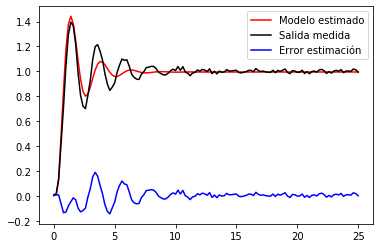

In [63]:
## Definiendo la función de transferencia estimada ARX
_,ye = control.step_response(G_e,t)

## Ganancia de ajuste
k = 1;
ye = k*ye

## Señal de error estimado
e = yn-ye

plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.plot(t,e,color = 'blue')
plt.legend(['Modelo estimado','Salida medida','Error estimación'])

print(G_e)

## Planteando el nuevo regresor

**Paso 5:** Se va propone un nuevo regresor que incluya la señal de error estimada en el paso anterior

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3],e[k-1],e[k-2],e[k-3]]$$

In [64]:
e_1 = np.zeros(N)
e_2 = np.zeros(N)
e_3 = np.zeros(N)

for k in range(1,N):
    e_1[k]=e[k-1]
for k in range(2,N):
    e_2[k]=e[k-2]
for k in range(3,N):
    e_3[k]=e[k-3]
## Creación del vector phi
phi2 = np.array([-y_1,-y_2,-y_3,u_1,u_2,u_3,e_1,e_2,e_3]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

Am = np.dot(phi2.T,phi2) + alpha*np.eye(len(np.dot(phi2.T,phi2)))
theta2 = np.dot(np.linalg.inv(Am),np.dot(phi2.T,yn))
theta2

array([-1.24530771,  0.34225554,  0.20980751,  0.0069915 ,  0.11223638,
        0.18609535, -0.18557401,  0.31443587, -0.23584072])

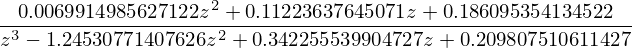

In [65]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A

## Construir los polinomios A(z) y B(z)
A = 1 + theta2[0]*z**-1 + theta2[1]*z**-2+ theta2[2]*z**-3  
B = theta2[3]*z**-1+theta2[4]*z**-2+theta2[5]*z**-3 
C = 1 + theta2[6]*z**-1 + theta2[7]*z**-2 + theta2[8]*z**-3 
G = (B/A).simplify()
G

TransferFunction(array([0.0069915 , 0.11223638, 0.18609535]), array([ 1.        , -1.24530771,  0.34225554,  0.20980751]), 0.2)

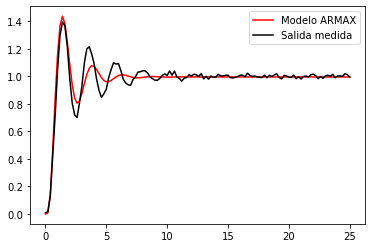

In [66]:
## Armando la función de transferencia estimada con los parámetros hallados
G2 = control.tf([theta2[3],theta2[4],theta2[5]],[1,theta2[0],theta2[1],theta2[2]],dt)

## Se determina la respuesta estimada al escalón
_,y2 = control.step_response(G2,t)

e2 = yn-y2

plt.plot(t,y2,color = 'red')
plt.plot(t,yn,color = 'black')
#plt.plot(t,e2,color = 'green')

plt.legend(['Modelo ARMAX','Salida medida','Error estimacion']);
G2

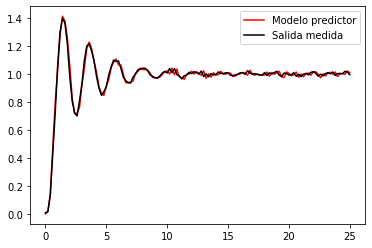

In [67]:
## Armando la función estimada con los parámetros hallados y usando el predictor.

yf = (-theta2[0]*y_1 - theta2[1]*y_2 - theta2[2]*y_3 + 
      theta2[3]*u_1 + theta2[4]*u_2 + theta2[5]*u_3 + 
      0*(theta2[6]*e_1+theta2[7]*e_2+theta2[8]*e_3)  )
plt.plot(t,yf,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo predictor','Salida medida'])

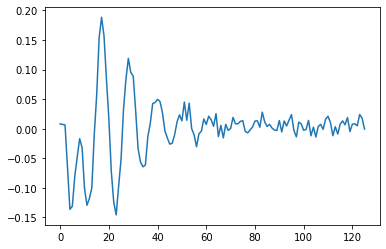

In [68]:
plt.plot(e)